In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
import os, re
import gpudb
import sys
from matplotlib import pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
import plotly
import Model
import util
from util import getRecord, topN_drug, cluster
plotly.tools.set_credentials_file(username='rewreu', api_key='0rfHEVbuwMPJytN18N58')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Num_records = -1 # use -1 to get all the records
drug_tab = getRecord(num_records=Num_records, offset=0, HOSTIP="127.0.0.1", 
                     port="9191",table_name="DRUG_TID")
drug_dict = pd.Series(drug_tab.GENERIC_NAME.values,index=drug_tab.TID).to_dict()

In [2]:
# read major patient data
if 'm' not in locals():
    m = getRecord(num_records=Num_records,offset=0, 
                  HOSTIP="127.0.0.1", port="9191", table_name="PATIENT_history_cat")

### Construct rating matrix

In [3]:
df_non_norm = pd.crosstab(m.PATIENT_ID, m.TID, m.rx_count, aggfunc=np.sum, normalize=False).fillna(0)
df2_non_norm = df_non_norm.values
drugID2Count=np.sum(df_non_norm,axis=0).to_dict()

In [4]:
df = pd.crosstab(m.PATIENT_ID, m.TID, m.rx_count, aggfunc=np.sum, normalize='index').fillna(0)
df2 = df.values # same as as_matrix() method

In [5]:
df.head(2)

TID,1002,1013,104,105,106,108,11,1133,1139,1149,...,947,95,954,960,963,977,981,986,990,994
PATIENT_ID,,,,,,,,,,,,,,,,,,,,,
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.006211,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Variational Auto encoder

## with row Normalization

In [6]:
batch_size = 80
learning_rate = 2e-4
graph_1 = tf.Graph()
num_drugs = 493
AutoEnc2 = Model.cvae(learning_rate = learning_rate, batch_size = batch_size, num_drugs = num_drugs, doubled = False)
AutoEnc2.train(df2, 10)
vaeRec_encoded = AutoEnc2.encodeInfer(df2)
vaeRec = AutoEnc2.infer(df2)

Instructions for updating:
Use the retry module or similar alternatives.
epoch: 0, value: 0.0012881478760391474
epoch: 1, value: 0.0010268936166539788
epoch: 2, value: 0.0007814363343641162
epoch: 3, value: 0.0006335247308015823
epoch: 4, value: 0.0005599199794232845
epoch: 5, value: 0.0005236053257249296
epoch: 6, value: 0.0005008012522011995
epoch: 7, value: 0.00048314829473383725
epoch: 8, value: 0.0004691074136644602
epoch: 9, value: 0.0004569624434225261


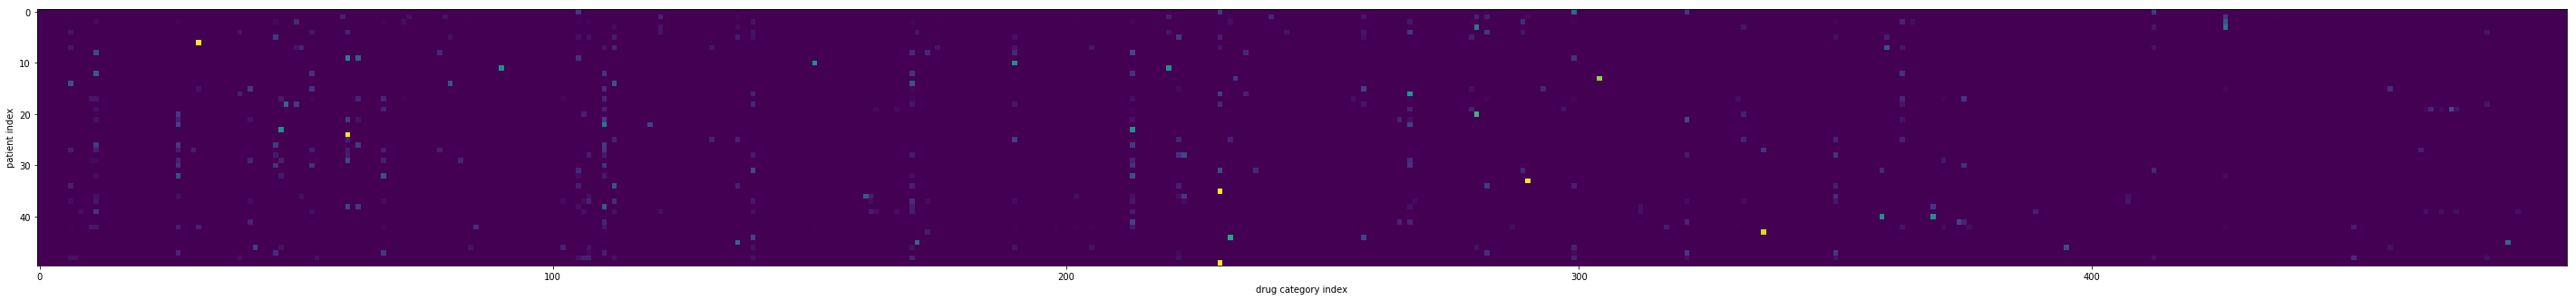

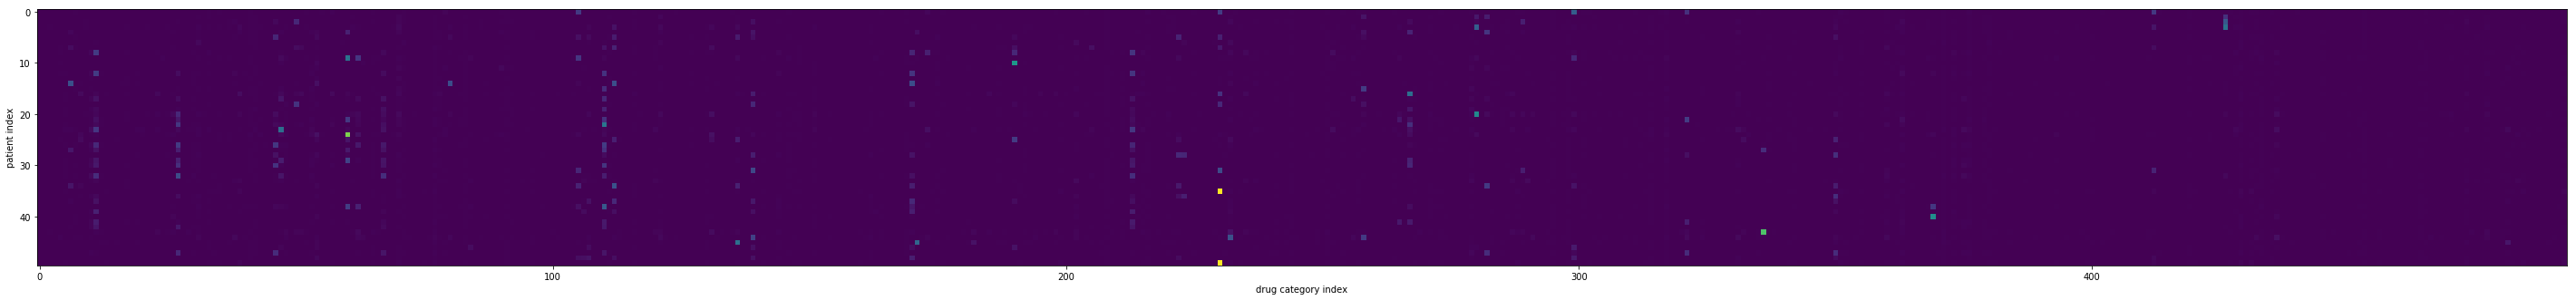

In [7]:
util.mat_plot(df2, 50)
util.mat_plot(vaeRec, 50)

idx,   count,     TID,                        GENERIC_NAME, drug_rating, drug_total
  0,    4641,    2750,        TRIAMCINOLONE HEXACETONIDE I,  0.055937,   4571
  0,    4641,     320,         DEXTROMETHORPHAN POLISTIREX,  0.069397,   4374
  0,    4641,    2737,              FIDAXOMICIN TAB 200 MG,  0.079136,   3497
  0,    4641,     301,        TRIAMCINOLONE ACETONIDE NASA,  0.083871,   5947
  0,    4641,    5970,        PIRBUTEROL ACETATE BREATH AC,  0.105442,   6685

  1,     936,    2623,        AMPICILLIN & SULBACTAM SODIU,  0.019248,   1483
  1,     936,     457,            PALONOSETRON HCL IV SOLN,  0.020058,   2403
  1,     936,      11,               CEPHALEXIN TAB 500 MG,  0.020259,   3214
  1,     936,    2501,        ZANAMIVIR AERO POWDER BREATH,  0.023365,   693
  1,     936,       3,        AMPICILLIN SODIUM FOR IV SOL,  0.663013,   4603

  2,   11928,    3925,                OXAPROZIN TAB 600 MG,  0.010527,   5776
  2,   11928,     530,            SERTRALINE HCL TAB 50 M

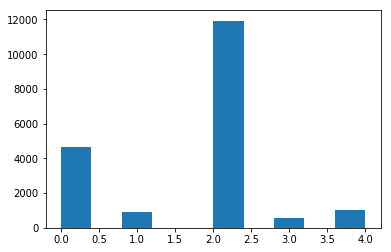

In [8]:
cluster(df, vaeRec_encoded, AutoEnc2, 5,
        drug_dict=drug_dict, drug_id_to_count=drugID2Count)

## Without row normalization

In [9]:
batch_size = 80
learning_rate = 2e-4
graph_1 = tf.Graph()
num_drugs = 493
AutoEnc2_nn = Model.cvae(learning_rate = learning_rate, batch_size = batch_size, num_drugs = num_drugs, doubled = False)
AutoEnc2_nn.train(df2_non_norm, 10)
vaeRec_encoded_nn = AutoEnc2_nn.encodeInfer(df2_non_norm)
vaeRec_nn = AutoEnc2_nn.infer(df2_non_norm)

epoch: 0, value: 0.00494017731398344
epoch: 1, value: 0.004517223220318556
epoch: 2, value: 0.0041030049324035645
epoch: 3, value: 0.0037886332720518112
epoch: 4, value: 0.0035261441953480244
epoch: 5, value: 0.0033099399879574776
epoch: 6, value: 0.0031215501949191093
epoch: 7, value: 0.0029655955731868744
epoch: 8, value: 0.0028316329699009657
epoch: 9, value: 0.002725155558437109


idx,   count,     TID,                        GENERIC_NAME, drug_rating, drug_total
  0,    1796,    3510,            GLUCOSE BLOOD TEST STRIP,  0.855944,   5266
  0,    1796,     156,        METFORMIN HCL TAB SR 24HR MO,  1.217542,   6195
  0,    1796,     224,               TRANDOLAPRIL TAB 4 MG,  1.327438,   6430
  0,    1796,    2530,        NEBIVOLOL HCL TAB 5 MG (BASE,  1.769648,   6867
  0,    1796,    2747,               SIMVASTATIN TAB 80 MG,  3.271181,   13511

  1,     133,     445,        RABEPRAZOLE SODIUM EC TAB 20,  2.591949,   4322
  1,     133,    6030,            PREGABALIN SOLN 20 MG/ML,  3.609276,   3007
  1,     133,    6637,        HYDROCODONE-ACETAMINOPHEN TA,  3.972320,   10113
  1,     133,     649,        TIZANIDINE HCL TAB 4 MG (BAS,  5.826219,   4982
  1,     133,     583,        TRAMADOL HCL TAB ER 24HR BIP,  17.491669,   5625

  2,   16285,    2750,        TRIAMCINOLONE HEXACETONIDE I,  0.182157,   4571
  2,   16285,    5970,        PIRBUTEROL ACETATE BREA

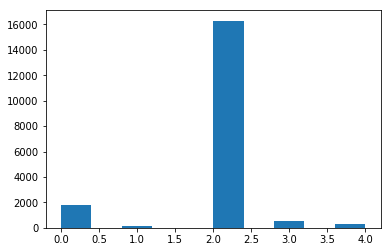

In [10]:
cluster(df, vaeRec_encoded_nn, AutoEnc2_nn, 5,
        drug_dict=drug_dict, drug_id_to_count=drugID2Count)

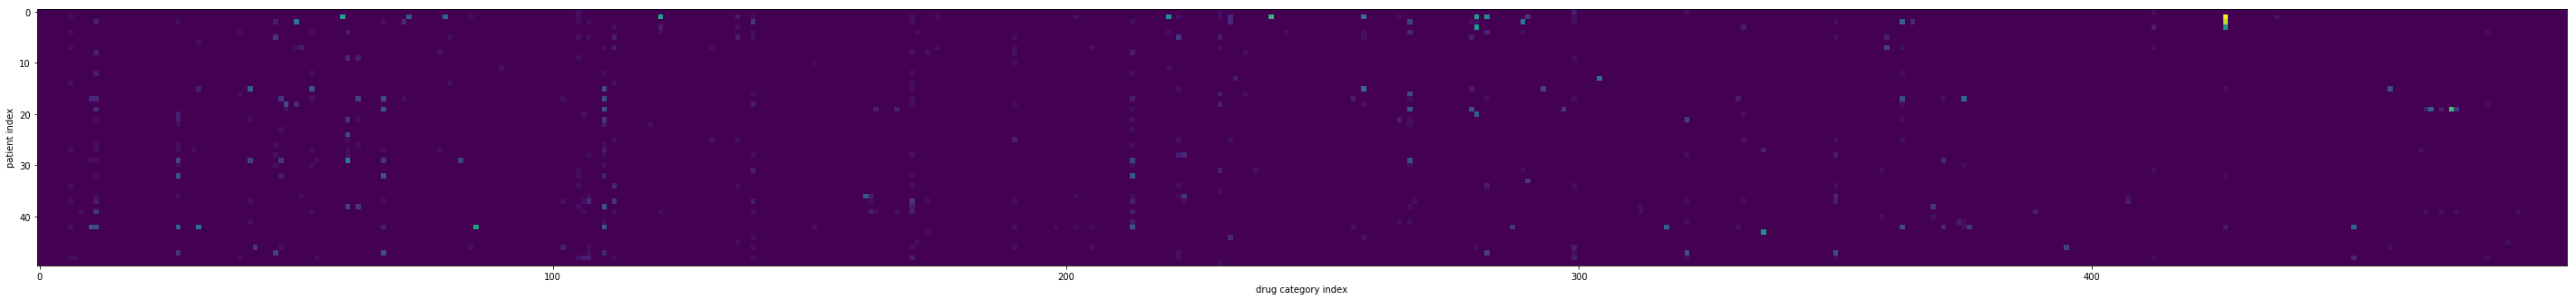

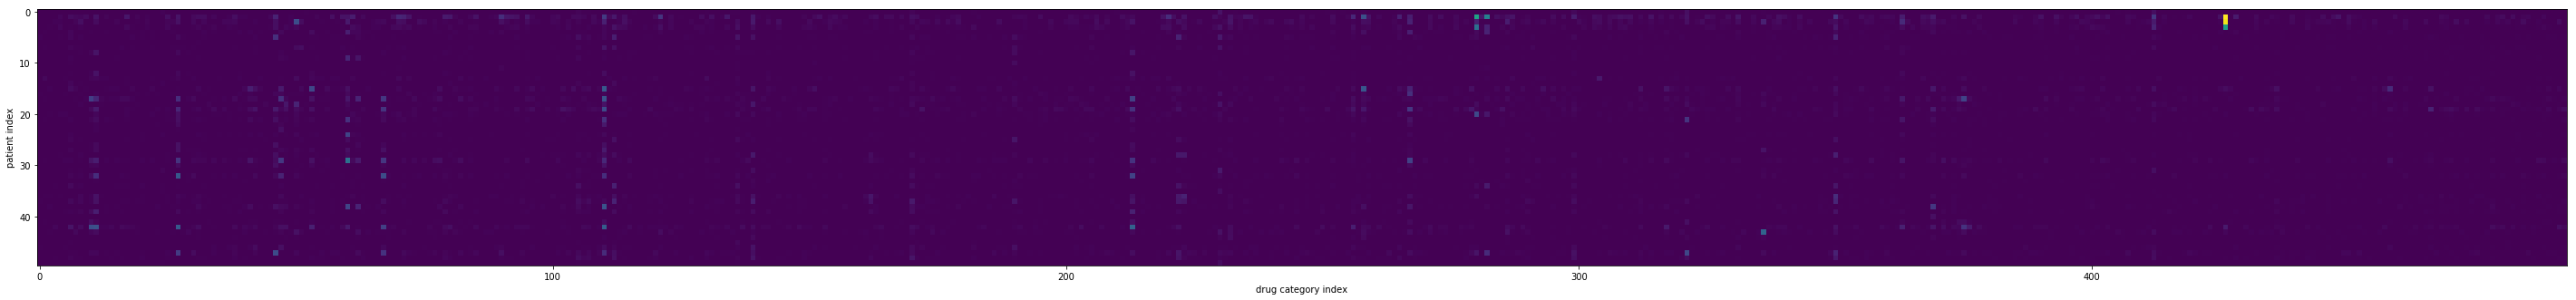

In [11]:
util.mat_plot(df2_non_norm, 50)
util.mat_plot(vaeRec_nn, 50)

## AutoEncoder without row normalization

In [12]:
batch_size = 80
learning_rate = 2e-4
graph_1 = tf.Graph()
num_drugs = 493
AutoEnc3_nn = Model.AutoEnc(learning_rate = learning_rate, batch_size = batch_size, num_drugs = num_drugs, doubled = False)
AutoEnc3_nn.train(df2_non_norm, 15)
aeRec_encoded_nn = AutoEnc3_nn.encodeInfer(df2_non_norm)
aeRec_nn = AutoEnc3_nn.infer(df2_non_norm)

epoch: 0, loss: 0.005487594287842512
epoch: 1, loss: 0.005132187157869339
epoch: 2, loss: 0.004805841017514467
epoch: 3, loss: 0.0045784455724060535
epoch: 4, loss: 0.004410113207995892
epoch: 5, loss: 0.004265257623046637
epoch: 6, loss: 0.004135021474212408
epoch: 7, loss: 0.0040305620059370995
epoch: 8, loss: 0.003933914937078953
epoch: 9, loss: 0.003863873891532421
epoch: 10, loss: 0.0037887273356318474
epoch: 11, loss: 0.003729041200131178
epoch: 12, loss: 0.0036858785897493362
epoch: 13, loss: 0.003633652813732624
epoch: 14, loss: 0.0035962965339422226


idx,   count,     TID,                        GENERIC_NAME, drug_rating, drug_total
  0,    2152,     224,               TRANDOLAPRIL TAB 4 MG,  0.660537,   6430
  0,    2152,     301,        TRIAMCINOLONE ACETONIDE NASA,  0.663490,   5947
  0,    2152,     156,        METFORMIN HCL TAB SR 24HR MO,  0.708967,   6195
  0,    2152,    2530,        NEBIVOLOL HCL TAB 5 MG (BASE,  1.166874,   6867
  0,    2152,    2747,               SIMVASTATIN TAB 80 MG,  2.472296,   13511

  1,     117,    5970,        PIRBUTEROL ACETATE BREATH AC,  3.381340,   6685
  1,     117,    2747,               SIMVASTATIN TAB 80 MG,  3.529893,   13511
  1,     117,    6637,        HYDROCODONE-ACETAMINOPHEN TA,  4.162345,   10113
  1,     117,     649,        TIZANIDINE HCL TAB 4 MG (BAS,  5.993858,   4982
  1,     117,     583,        TRAMADOL HCL TAB ER 24HR BIP,  21.092443,   5625

  2,     284,    6030,            PREGABALIN SOLN 20 MG/ML,  2.327008,   3007
  2,     284,     523,                  OXAZEPAM CAP

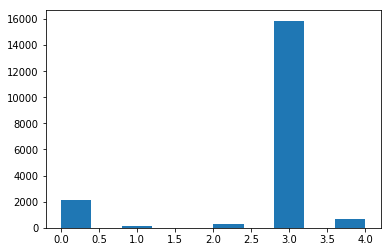

In [13]:
cluster(df, aeRec_encoded_nn, AutoEnc3_nn, 5, 
        drug_dict=drug_dict, drug_id_to_count=drugID2Count)

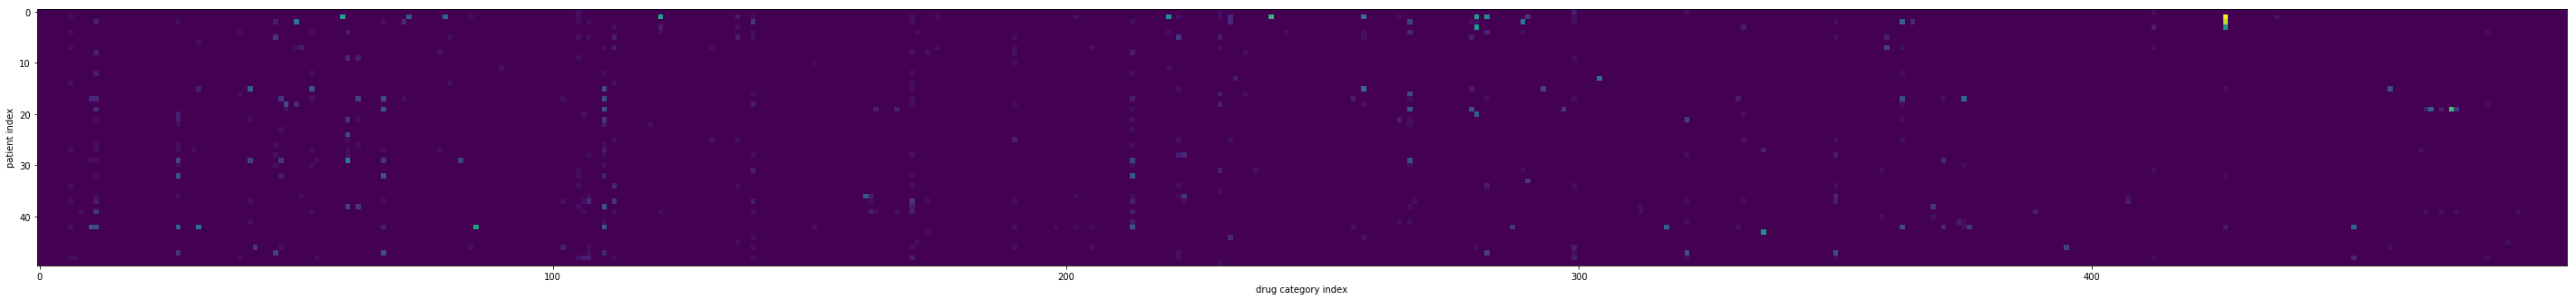

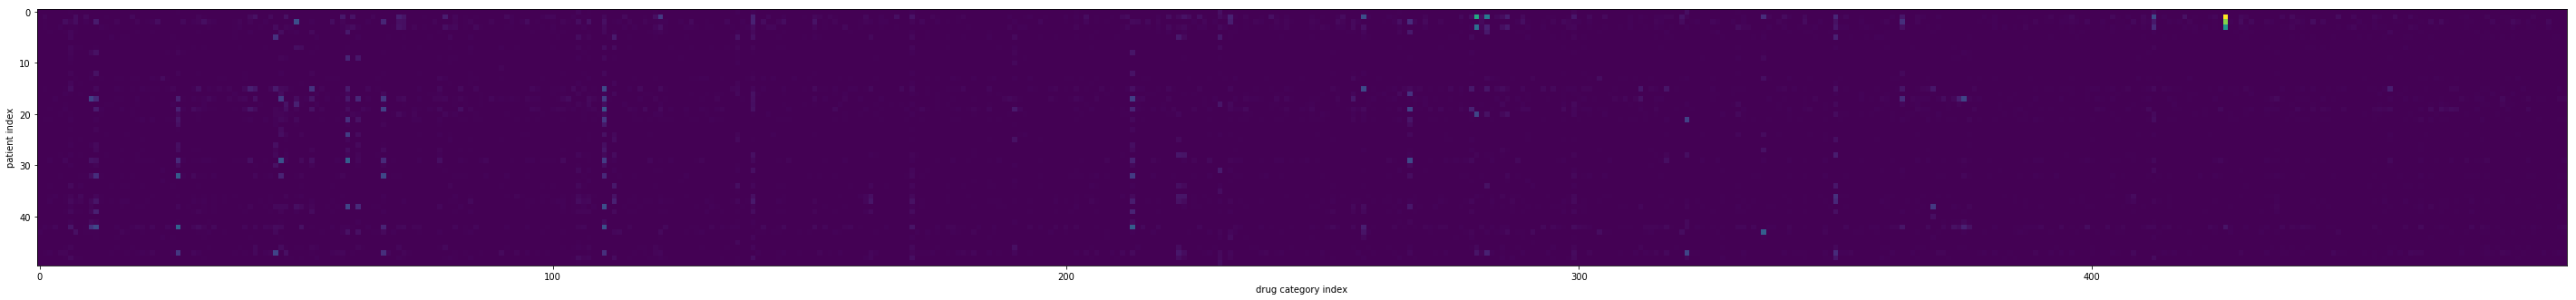

In [14]:
util.mat_plot(df2_non_norm, 50)
util.mat_plot(aeRec_nn, 50)

## Visualize a subset of Autoencoder result in 3D T-sne

This may take up to a few minutes

In [15]:
import plotly.plotly as py
data = aeRec_nn[:1000]
fig = util.Visualize3DTsne(data)
py.iplot(fig, filename='AE-Clustering-3d_')

[t-SNE] Computing 361 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.012s...
[t-SNE] Computed neighbors for 1000 samples in 0.907s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.762060
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.543335
[t-SNE] Error after 600 iterations: 0.812943
